<a href="https://colab.research.google.com/github/danishbq/PlayingCardClassifier-EfficientNet-CNN/blob/main/Playing_Card_Classifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mounting Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Connecting Data set from Kaggle

In [2]:
!pip install kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle'

In [23]:
#!kaggle datasets download gpiosenka/cards-image-datasetclassification -p "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle"

dataset_path = "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification.zip"

# Check if the dataset is already downloaded
if not os.path.exists(dataset_path):
    # Download the dataset if the .zip file doesn't exist
    !kaggle datasets download gpiosenka/cards-image-datasetclassification -p "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle"
else:
    print("Dataset already downloaded.")

Dataset already downloaded.


In [24]:
#!unzip "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification.zip" -d "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification"

zip_file_path = "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification.zip"
unzip_dir_path = "/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification"

# Check if the dataset has already been unzipped
if not os.path.exists(unzip_dir_path) or len(os.listdir(unzip_dir_path)) == 0:
    # Unzip only if the folder doesn't exist or is empty
    !unzip "{zip_file_path}" -d "{unzip_dir_path}"
else:
    print("Dataset already unzipped.")

Dataset already unzipped.


# 3. Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm    #timm has a lot of good image classification models

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
PyTorch version 2.4.1+cu121
Torchvision version 0.19.1+cu121
Numpy version 1.26.4
Pandas version 2.2.2


# 4. Loading Data

In [5]:
#this class inherits from PyTorch's main Dataset class
class PlayingCardDataset(Dataset) :

  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [6]:
#training dataset

dataset = PlayingCardDataset(data_dir='/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/train')

In [7]:
len(dataset)

7624

In [11]:
dataset[4000]

(<PIL.Image.Image image mode=RGB size=224x224>, 27)

27


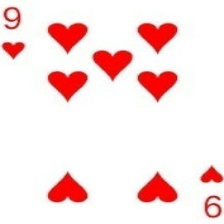

In [12]:
#visualizing a sample from training

image, label = dataset[4000]
print(label)
image

In [13]:
# making a dictionary to connect target values with folder names
# the train directory has separate folders for each card with the name of card as folder name. the folder has multiple impages of the same card
# the dictionary has labels as key and folder name (card name) as values

data_dir = '/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [15]:
#transforming data set to same size

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

data_dir = '/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [16]:
dataset[4000]

(tensor([[[0.9843, 0.9922, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
          [0.9882, 0.9922, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
          [0.9882, 0.9804, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9804, 0.9882, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9843, 0.9922]],
 
         [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9922, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9804, 0.9804],
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9843, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 0.9961]],
 
         [[0.9961, 0.9961, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
          [0.9647, 0.9647, 0.9647,  ...,

In [22]:
image, label = dataset[4000]
print(image)
print(image.shape)
print(label)

tensor([[[0.9843, 0.9922, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9922, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9804, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9804, 0.9882, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9843, 0.9922]],

        [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9922, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9804, 0.9804],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9843, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 0.9961]],

        [[0.9961, 0.9961, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
         [0.9843, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
         [0.9647, 0.9647, 0.9647,  ..., 1.0000, 1.0000, 1.

Creating a Dataloader

In [25]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
for images, labels in dataloader:
  break

In [27]:
images.shape

torch.Size([32, 3, 128, 128])

In [33]:
labels.shape

torch.Size([32])

# 5. PyTorch Model

In [38]:
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier, self).__init__()
        # parts of the model defined
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [39]:
model = CardClassifier(num_classes=53)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [46]:
test_output = model(images)
print(test_output)
print(test_output.shape)

tensor([[ 0.2011, -0.2056, -0.1132,  ...,  0.6156,  0.6041, -0.2269],
        [ 0.1731, -0.3680, -0.1869,  ...,  0.1266, -0.2148, -0.1194],
        [-0.4924, -0.0408, -0.3003,  ..., -0.4643,  0.0583, -0.1924],
        ...,
        [-0.4419,  0.4642,  0.0241,  ..., -0.0973,  0.1166, -0.2946],
        [ 0.4695, -0.1885,  0.2441,  ..., -0.0443, -0.2131,  0.3660],
        [-0.4016, -0.3436, -0.0336,  ...,  0.2133, -0.0483,  0.0912]],
       grad_fn=<AddmmBackward0>)
torch.Size([32, 53])


# 6. Training

In [44]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
# testing the loss funtion
criterion(test_output, labels)

tensor(3.9984, grad_fn=<NllLossBackward0>)

In [48]:
# All datasets - train, valid, test

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/train/'
valid_folder = '/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/valid/'
test_folder = '/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [58]:
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.get_device_name(0))  # This will print the name of the GPU

True
Tesla T4


In [59]:
num_epochs = 5
train_losses, val_losses = [], []

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.6213376193081595, Validation loss: 0.3659015680259129


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5804695103626312, Validation loss: 0.33462812248265966


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.35603194825296514, Validation loss: 0.1575634000436315


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.25170084063241266, Validation loss: 0.14793174682923083


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.20144755336390524, Validation loss: 0.15692288290779546


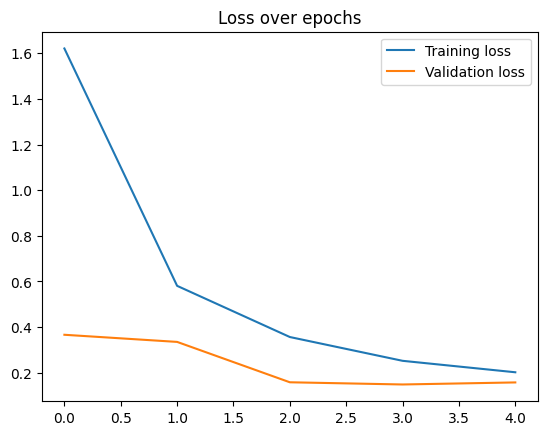

In [60]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

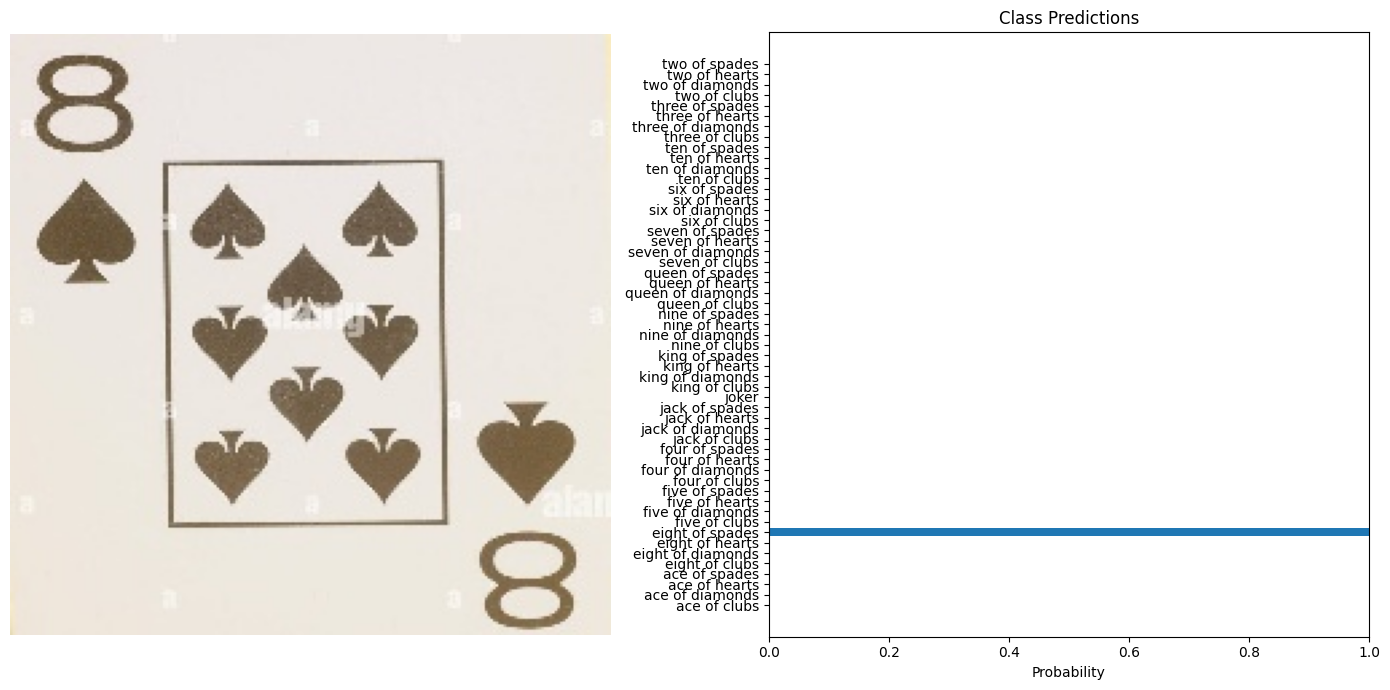

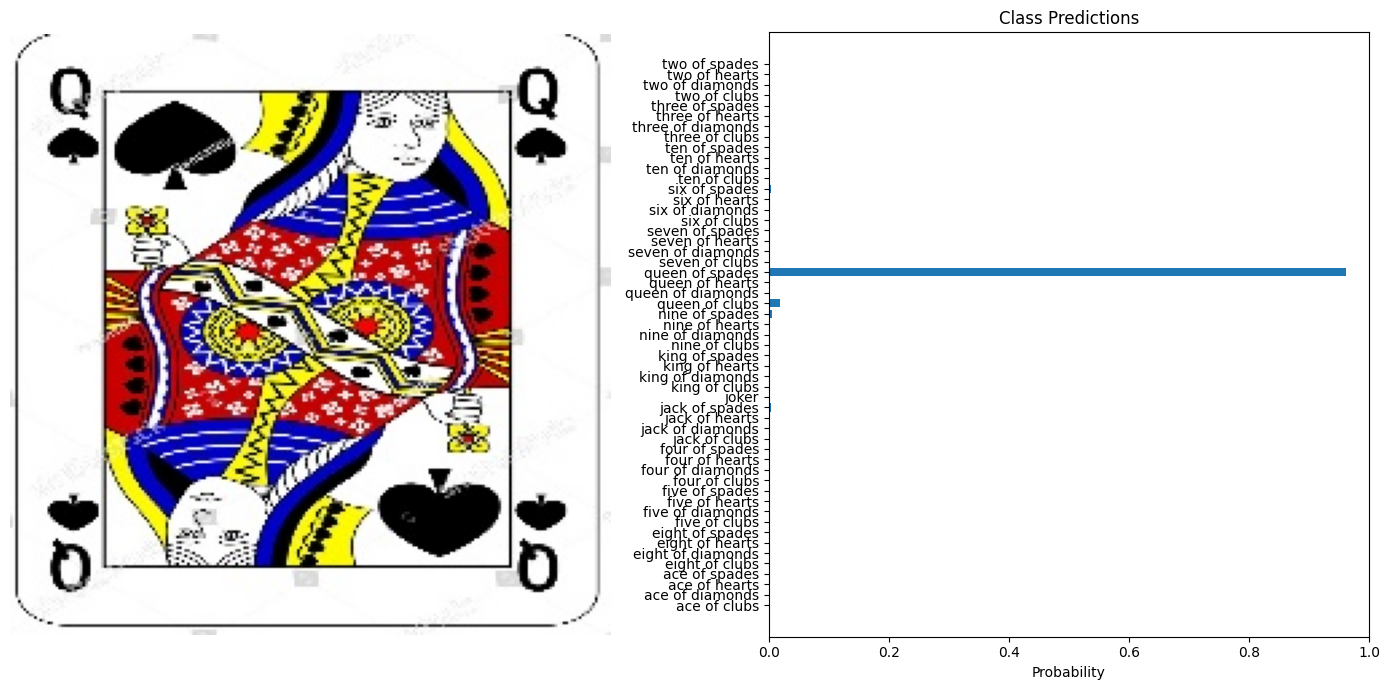

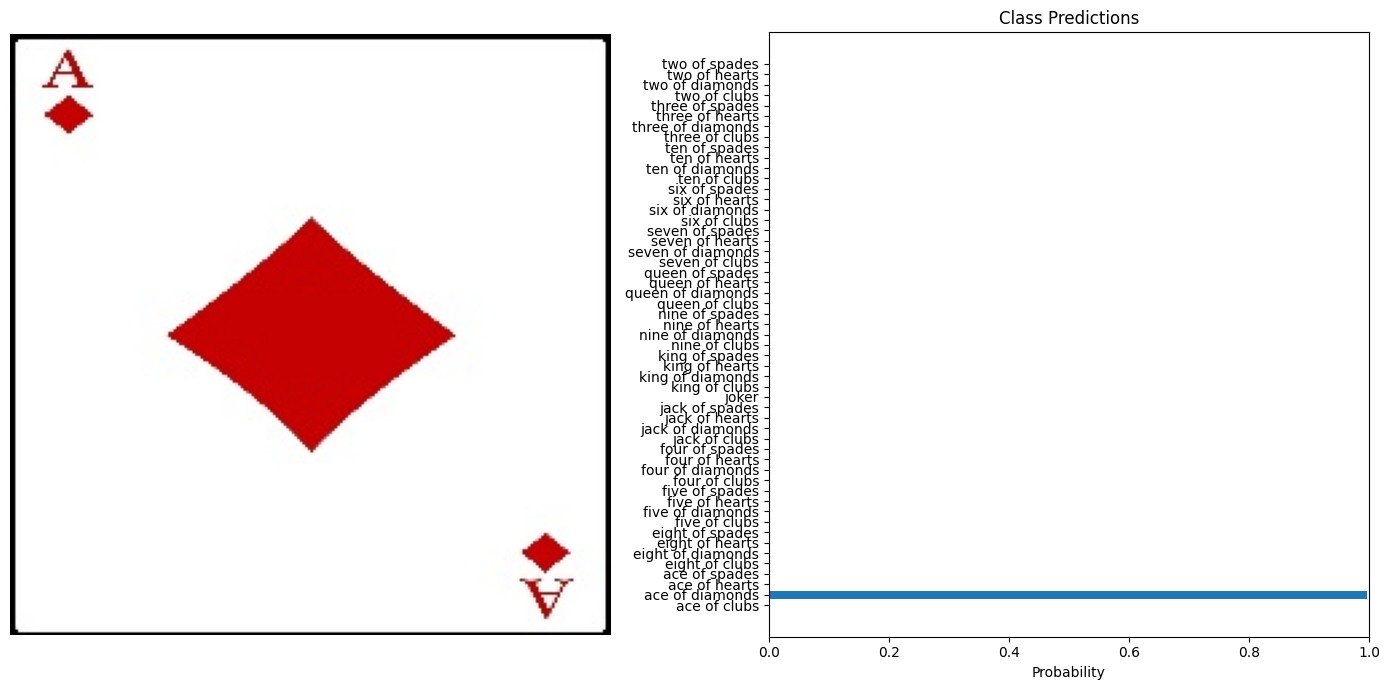

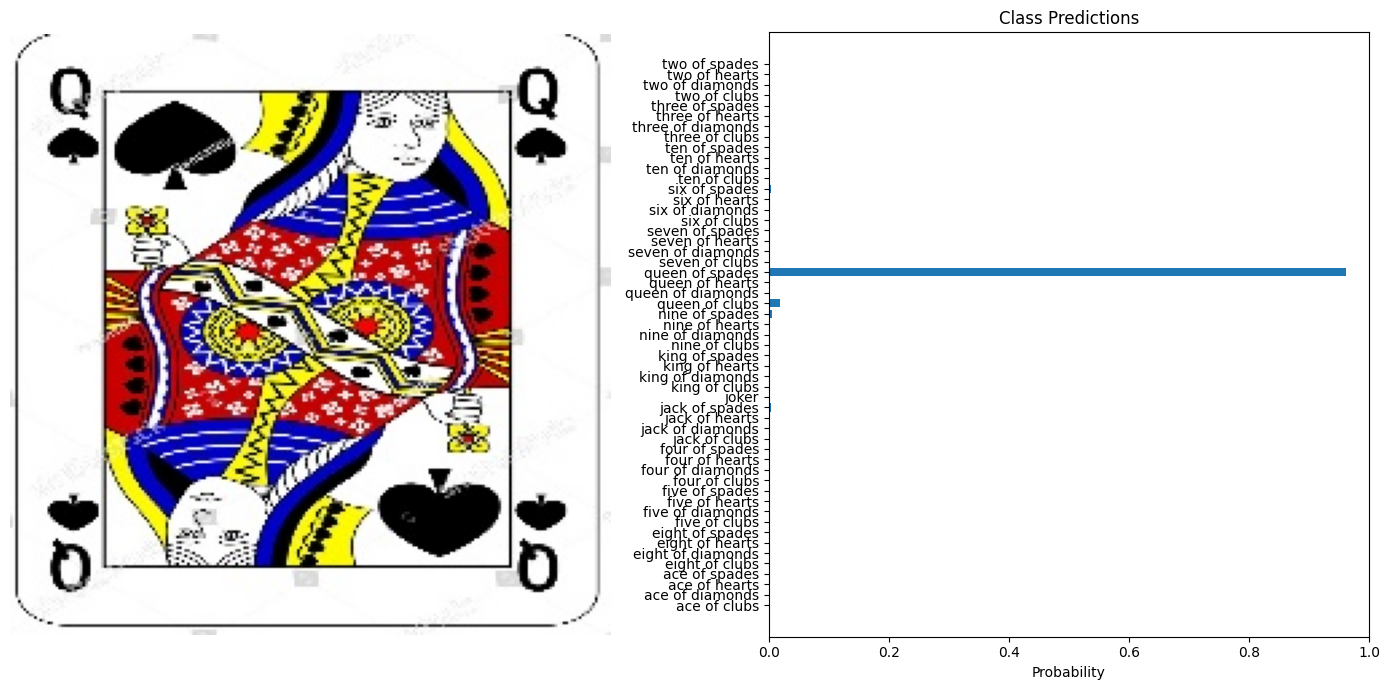

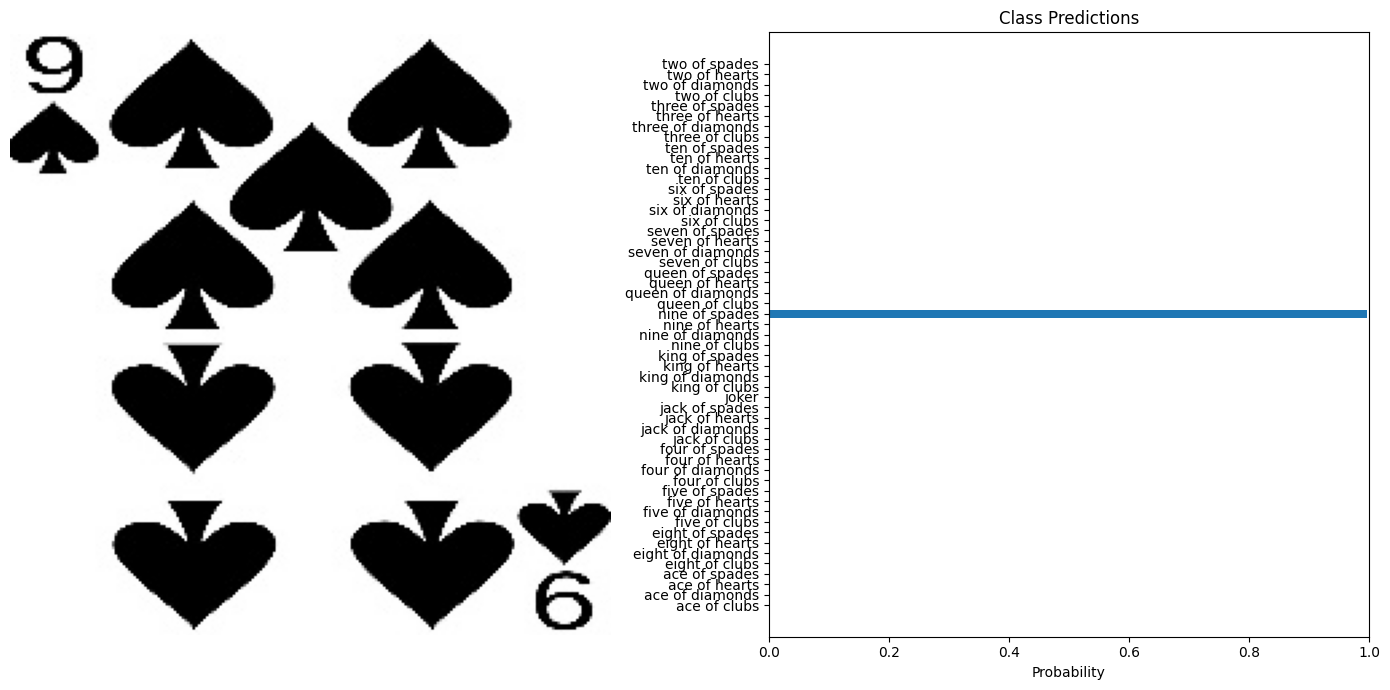

In [62]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

from glob import glob
test_images = glob('/content/drive/MyDrive/PyTorch Playing Cards Classifier/kaggle/cards-image-datasetclassification/test/*/*')
test_sample = np.random.choice(test_images, 5)

for sample in test_sample:
    original_image, image_tensor = preprocess_image(sample, transform)
    probabilities = predict(model, image_tensor, device)

    # dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)